In [1]:
import sys
import os


sys.path.append(os.path.abspath(r"C:\Users\sofi loran\Documents\Model TP"))
from imports import *

In [2]:
file_path = 'Rabbit_B_SHAP_SVM.xlsx'
df = pd.read_excel(file_path)
df.head()

,PEOE_VSA11,EState_VSA2,VSA_EState6,SMR_VSA6,SMR_VSA10,PEOE_VSA9,fr_NH1,fr_amide,Irritation
0,0.000000,0.000000,0.000000,0.216018,0.000000,0.000000,0.000000,0.000000,1
1,0.000000,0.256312,0.000000,0.225150,0.208314,0.230156,0.000000,0.000000,1
2,0.680370,0.456627,0.403000,0.217041,0.292175,0.361580,0.408248,0.408248,0
3,0.392847,0.508912,0.282099,0.373221,0.290325,0.385121,0.408248,0.408248,0
4,0.000000,0.448460,0.226058,0.285657,0.583650,0.205850,0.408248,0.912871,0


In [3]:
df.shape

(857, 9)

In [4]:
print(df.columns.to_list())

['PEOE_VSA11', 'EState_VSA2', 'VSA_EState6', 'SMR_VSA6', 'SMR_VSA10', 'PEOE_VSA9', 'fr_NH1', 'fr_amide', 'Irritation']


In [5]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  
y = df['Irritation']

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 685 samples
Test set: 172 samples


In [7]:
def objective(trial):

    param = {
        "C": trial.suggest_float("C", 0.1, 10),
        "kernel": trial.suggest_categorical("kernel", ["rbf"]),
        "gamma": "scale",
        "class_weight": "balanced",
    }
    

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = SVC(**param, probability=True) 
        model.fit(X_train_cv, y_train_cv)
 
        valid_acc = f1_score(y_valid_cv, model.predict(X_valid_cv))
        valid_scores.append(valid_acc)

    return np.mean(valid_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)

[I 2025-10-27 20:31:49,879] A new study created in memory with name: no-name-ae2fd477-6445-4277-a47b-a4b6723db80a
[I 2025-10-27 20:31:50,901] Trial 0 finished with value: 0.7467510030779441 and parameters: {'C': 4.1919909646611515, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7467510030779441.
[I 2025-10-27 20:31:51,937] Trial 1 finished with value: 0.7457825506659694 and parameters: {'C': 4.4047585834636465, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7467510030779441.
[I 2025-10-27 20:31:52,988] Trial 2 finished with value: 0.7413862486831448 and parameters: {'C': 4.865309648282188, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7467510030779441.
[I 2025-10-27 20:31:53,957] Trial 3 finished with value: 0.7516439285862336 and parameters: {'C': 1.0781352378405942, 'kernel': 'rbf'}. Best is trial 3 with value: 0.7516439285862336.
[I 2025-10-27 20:31:55,023] Trial 4 finished with value: 0.7429806553472198 and parameters: {'C': 7.006541286336149, 'kernel': 'rbf'}. Best is trial 3 

Best trial: {'C': 1.5440543709603538, 'kernel': 'rbf'}


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

best_params = study.best_trial.params

# Initialize the SVM model with best parameters
final_model = SVC(**best_params, probability=True)

# Fit the model
final_model.fit(X_train, y_train)

# Accuracy
train_accuracy = final_model.score(X_train, y_train)
test_accuracy = final_model.score(X_test, y_test)

# Predictions
y_pred = final_model.predict(X_test)

# Metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Train Accuracy: 0.8043795620437956
Test Accuracy: 0.7906976744186046
Precision: 0.75
Recall: 0.75
F1 Score: 0.75


In [9]:
test_accuracies = []
train_accuracies = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    best_params = study.best_trial.params

    # Initialize the KNN model with best parameters
    final_model = SVC(**best_params, probability=True)

    # Fit the model on the training data
    final_model.fit(X_train, y_train)


    test_accuracy = final_model.score(X_test, y_test)
    train_accuracy = final_model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    #print("Test Accuracy:", test_accuracy)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(np.mean(train_accuracies), np.mean(test_accuracies))

0.8138686131386862 0.7680232558139535


Final Model Accuracy on Test: 0.7034883720930233


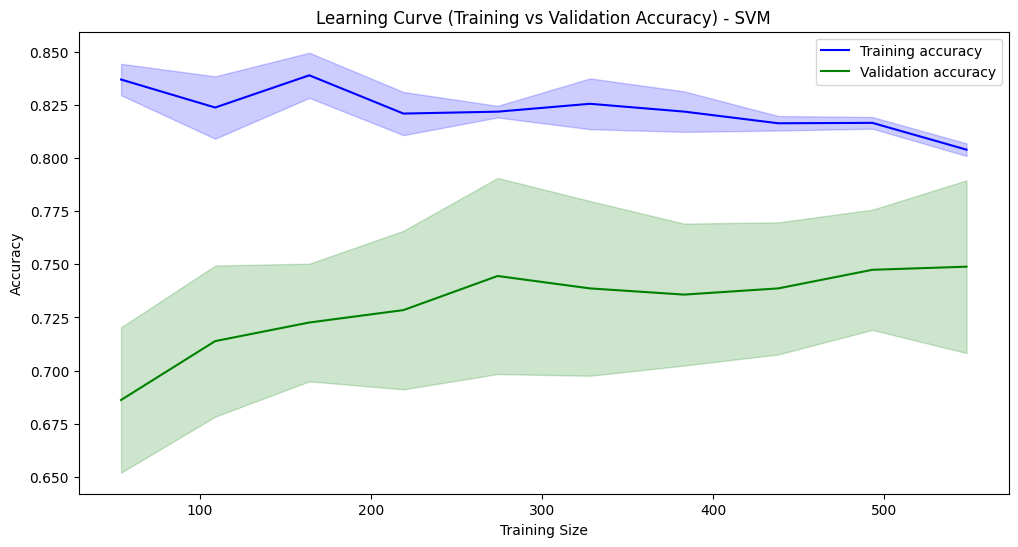

Train Accuracy: 0.8
Test Accuracy: 0.7034883720930233


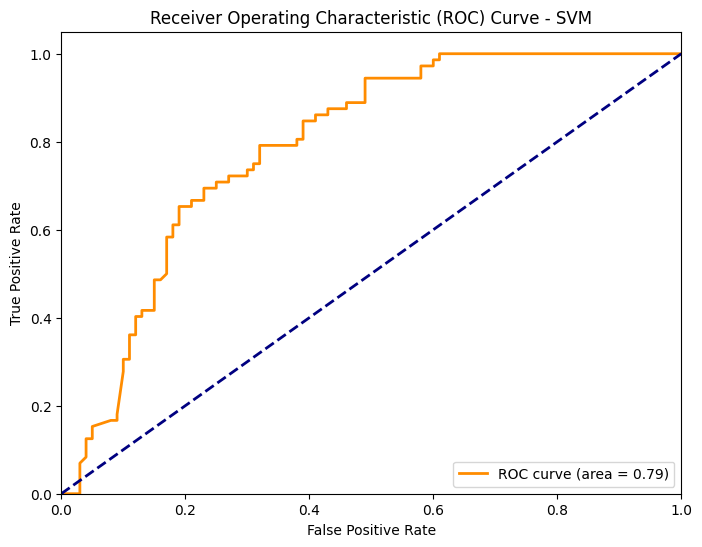

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt

# Get best hyperparameters from study
best_params = study.best_trial.params
best_params =  {'C': 0.6279728945930269, 'kernel': 'poly'}

# Initialize the KNN model with best parameters
final_model = SVC(**best_params, probability=True)

# Fit the model on the training data
final_model.fit(X_train, y_train)

# Evaluate final model on test data
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy on Test:", accuracy_score(y_test, y_pred_final))

# Learning Curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy) - SVM')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# ROC Curve
y_prob = final_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc='lower right')
plt.show()


In [11]:
sample_X = shap.sample(X_train, 200) 

background_summary = shap.sample(X_train, 25)
explainer = shap.KernelExplainer(final_model.predict_proba, background_summary)

shap_values = explainer.shap_values(sample_X)

  0%|          | 0/200 [00:00<?, ?it/s]

AssertionError: Feature and SHAP matrices must have the same number of rows!

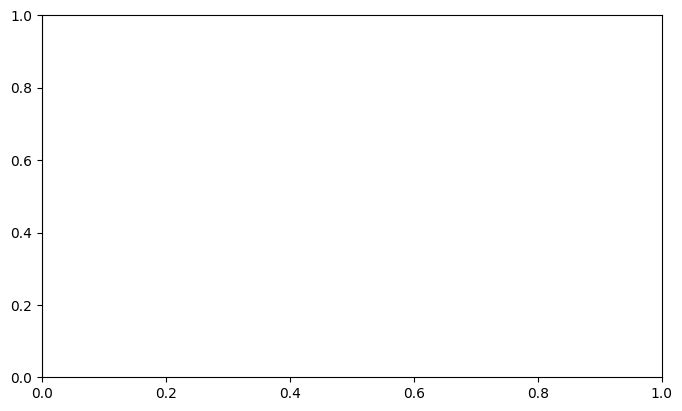

In [12]:
shap.summary_plot(shap_values[:,:,1], X_train)

In [13]:
import joblib

joblib.dump(final_model, 'svm_model.pkl')

print("Model saved successfully!")


Model saved successfully!


Train Accuracy: 0.8233576642335766
Test Accuracy: 0.7732558139534884
Precision: 0.7088607594936709
Recall: 0.7777777777777778
F1 Score: 0.7417218543046358


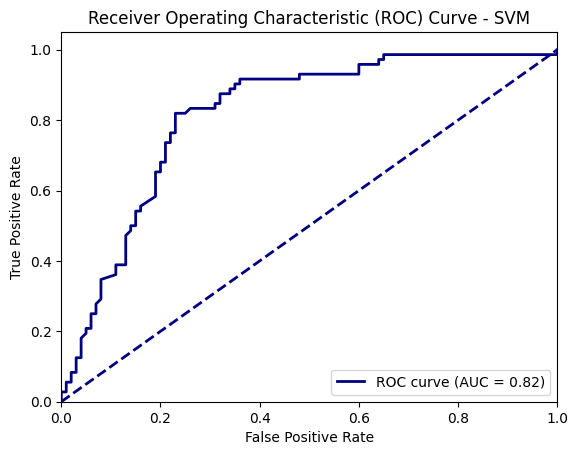

Calculating SHAP values...


  0%|          | 0/685 [00:00<?, ?it/s]

SHAP values shape: (685, 8, 2)


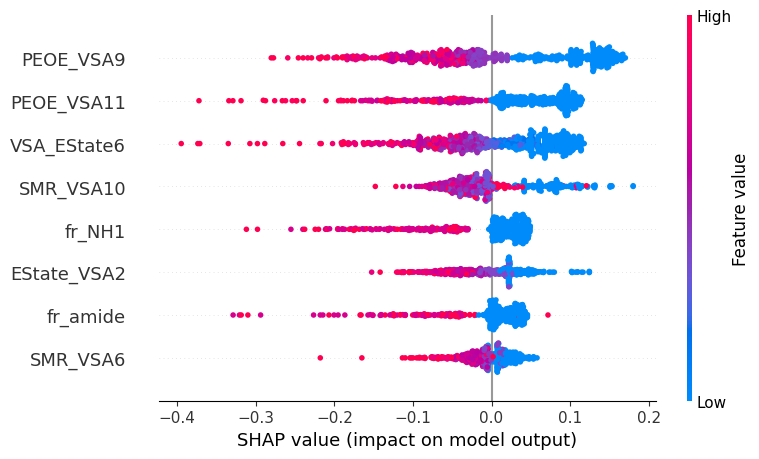

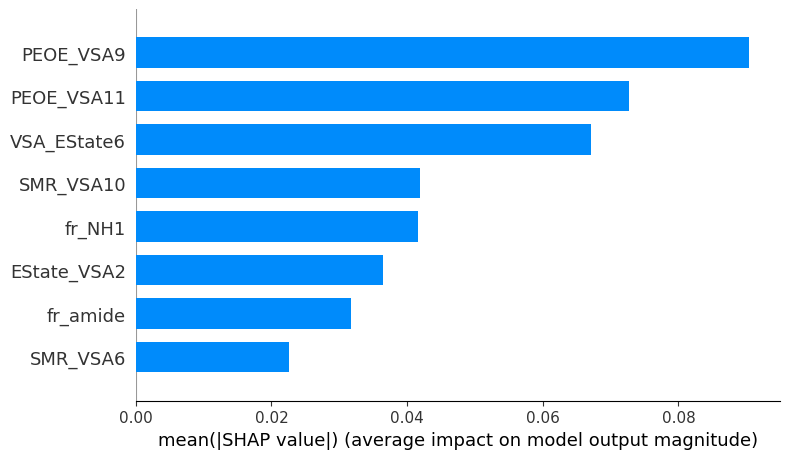

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import shap
import numpy as np

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

best_params = study.best_trial.params

# Initialize the SVM model with best parameters
final_model = SVC(**best_params, probability=True)

# Fit the model
final_model.fit(X_train, y_train)

# Accuracy
train_accuracy = final_model.score(X_train, y_train)
test_accuracy = final_model.score(X_test, y_test)

# Predictions
y_pred = final_model.predict(X_test)

# Metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# ROC Curve
y_proba = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc='lower right')
plt.show()

# SHAP Analysis - CORRECTED PART:
print("Calculating SHAP values...")

# Use smaller background data for speed
background_summary = shap.sample(X_train, 50)
explainer = shap.KernelExplainer(final_model.predict_proba, background_summary)

# Calculate SHAP values for ALL training data
shap_values = explainer.shap_values(X_train)

print(f"SHAP values shape: {np.array(shap_values).shape}")

# Visualization
shap.summary_plot(shap_values[:,:,1], X_train, feature_names=X_train.columns)

# Additional SHAP plots
shap.summary_plot(shap_values[:,:,1], X_train, plot_type="bar", feature_names=X_train.columns)